In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/config.json
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/tokenizer.json
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/metadata.json
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/model.weights.h5
/kaggle/input/deberta_v3/keras/deberta_v3_base_en/2/assets/tokenizer/vocabulary.spm
/kaggle/input/smart-contract-vulnerability-datset/SC_4label.csv
/kaggle/input/smart-contract-vulnerability-datset/SC_Vuln_8label.csv


# Install and import necessary dependencies

In [2]:
!pip install  keras_core keras_nlp 

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Input,Embedding,Flatten,TextVectorization,Conv1D,GlobalMaxPooling1D,MaxPooling1D,GlobalAveragePooling1D
from keras.initializers import Constant
from keras.layers import Dense,LSTM,Bidirectional,Attention,Concatenate,GRU,BatchNormalization
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [4]:
# Enable multiple gpus
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')


Using 0 GPU


In [5]:
data=pd.read_csv('/kaggle/input/smart-contract-vulnerability-datset/SC_4label.csv')
data

,Unnamed: 0,filename,code,label,label_encoded
0,0,36375.sol,pragma solidity ^0.4.15;\n\n/*\n\n CJX.io -...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
1,1,40298.sol,// <ORACLIZE_API>\n/*\nCopyright (c) 2015-2016...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
2,2,39858.sol,pragma solidity ^0.4.6;\n\n/*\n Copyright 2...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
3,3,34598.sol,pragma solidity ^0.4.4;\n\ncontract Token {\n\...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
4,4,33490.sol,pragma solidity ^0.4.13;\n\ncontract DSAuthori...,/content/drive/My Drive/SC_Dataset/reentrancy ...,2
...,...,...,...,...,...
2212,2212,9695.sol,\ncontract ERC223ReceivingContract {\n\n ...,/content/drive/My Drive/SC_Dataset/timestamp d...,3
2213,2213,8615.sol,pragma solidity ^0.4.13;\n\ncontract ERC20Basi...,/content/drive/My Drive/SC_Dataset/timestamp d...,3
2214,2214,7877.sol,pragma solidity ^0.4.24;\npragma experimental ...,/content/drive/My Drive/SC_Dataset/timestamp d...,3
2215,2215,6604.sol,pragma solidity 0.4.24;\n\n \n\n \nlibrary Saf...,/content/drive/My Drive/SC_Dataset/timestamp d...,3


# Label distribution

In [6]:
data['label_encoded'].value_counts()

label_encoded
2    1218
1     590
3     312
0      97
Name: count, dtype: int64

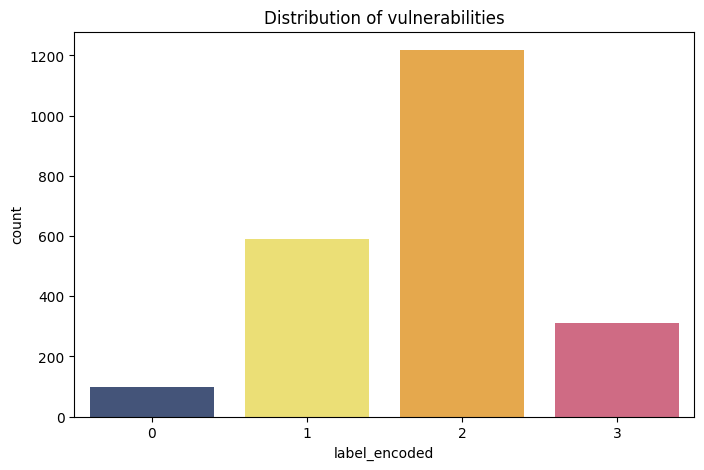

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors
custom_colors = ['#0a2463', '#FFEB3B', '#FF9800', '#d8315b']

plt.figure(figsize=(8, 5))

# Plot countplot with custom colors
sns.countplot(
    x=data['label_encoded'],
    palette=custom_colors,
    alpha=0.8
)

plt.title('Distribution of vulnerabilities')
plt.show()


# Preprocessing dataset

In [8]:
X = data['code']
y = data['label_encoded']

In [9]:
solidity_stopwords = [
    "pragma", "interface", "contract", "function", "event", "modifier", "library", "using",
    "string", "uint8", "uint256", "address", "mapping", "bool", "require", "return", "memory",
    "storage", "public", "internal", "view", "returns", "constant", "constructor",
    "_owner", "_balances", "_allowances", "_founder", "_marketing", "_who", "_burntAmount",
    "_from", "_to", "_value", "_timestamp", "_bool", "msg.sender", "totalSupply",
    "balanceOf", "transfer", "allowance", "approve", "transferFrom", "add", "sub", "mul", "div",
    "mod", "changeFounder", "setMinter", "setFurnace", "freezeAccount","solidity","bytes32"
]
def clean_solidity_code(solidity_code):
    # Remove comments (both single-line and multi-line)
    cleaned_code = re.sub(r'//.*?$', '', solidity_code, flags=re.MULTILINE)
    cleaned_code = re.sub(r'/\*.*?\*/', '', cleaned_code, flags=re.DOTALL)

    # Remove special characters and punctuation
    cleaned_code = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_code)

    # Remove extra whitespace and blank lines, and convert to lowercase
    cleaned_code = '\n'.join(line.strip().lower() for line in cleaned_code.splitlines() if line.strip())

    # Remove common English stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in cleaned_code.split() if word not in stop_words]
    tokens = [token for token in tokens if token not in solidity_stopwords]
    cleaned_code = ' '.join(tokens)

    return tokens

In [10]:
X_cleaned = X.apply(clean_solidity_code)

In [11]:
# Join the tokenized words back into sentences
X_cleaned_sentences = [' '.join(doc) for doc in X_cleaned]

In [12]:
X_cleaned_sentences=np.array(X_cleaned_sentences)


In [13]:
X_cleaned_sentences[1]

'oraclizei cbaddress queryuint timestamp datasource arg id querywithgaslimituint timestamp datasource arg uint gaslimit id query2uint timestamp datasource arg1 arg2 id query2withgaslimituint timestamp datasource arg1 arg2 uint gaslimit id getpricestring datasource uint dsprice getpricestring datasource uint gaslimit uint dsprice usecouponstring coupon setprooftypebyte prooftype setcustomgaspriceuint gasprice oraclizeaddrresolveri getaddress addr usingoraclize uint day 606024 uint week 6060247 uint month 60602430 byte prooftypenone 0x00 byte prooftypetlsnotary 0x10 byte proofstorageipfs 0x01 networkidauto 0 networkidmainnet 1 networkidtestnet 2 networkidmorden 2 networkidconsensys 161 oraclizeaddrresolveri oar oraclizei oraclize oraclizeapi oraclizeaddr oargetaddress oraclizeaddr 0 oraclizesetnetworknetworkidauto oraclizeaddr oargetaddress oraclize oraclizeioraclizeaddr couponstring code oraclize oraclizeioargetaddress oraclizeusecouponcode oraclizesetnetworkuint8 networkid returnsbool 

In [14]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_sentences, y,
                                                    test_size=0.1,shuffle=True,random_state=42,stratify=y)


# Tokenize and padding

In [15]:
# one hot encoding label
y_train_encoded = to_categorical(y_train, 4)
y_test_encoded = to_categorical(y_test, 4)
y_train_encoded

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [16]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [17]:
# Padding the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=128, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=128, padding='post', truncating='post')


In [18]:
print('Shape of training tensor: ', X_train_padded.shape)
print('Shape of testing tensor: ', X_test_padded.shape)

Shape of training tensor:  (1995, 128)
Shape of testing tensor:  (222, 128)


 #Oversampling dataset using SMOTE

In [19]:
#Smote oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
import math

In [20]:
def smote(x, y):
    k_neighbors = math.ceil(sum(y) * 0.01)
      
    smote = SMOTE(sampling_strategy=1, 
                  k_neighbors=k_neighbors)
    x, y = smote.fit_resample(x, y)
    
    return x, y
    
def bordersmote(x, y):
    k_neighbors = math.ceil(sum(y) * 0.01)
    m_neighbors = math.ceil(sum(y) * 0.01)
    
    bordersmote = BorderlineSMOTE(sampling_strategy=1, 
                                  k_neighbors=k_neighbors, 
                                  m_neighbors=m_neighbors)
    
    x, y = bordersmote.fit_resample(x, y)
    
    return x, y

In [21]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_padded, y_train_encoded)

In [22]:
y_train_resampled

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [23]:
label_counts = np.sum(y_train_resampled, axis=0)

# Display the label counts
print("Label Counts:", label_counts)

Label Counts: [1096  531 1096  281]


In [24]:
#getting the length of the maximum sequence in the dataset
max_length = max([len(w) for w in X_train])
print(max_length)

40222


In [25]:
emb_len=len(tokenizer.index_word)+1

#  BiLSTM CNN

In [26]:
# Input layer
input_layer = Input(shape=(128,))  # Specify max_len as the maximum sequence length

# Embedding layer
embedding_layer = Embedding(emb_len, 128)(input_layer)

# Bidirectional LSTM layer replaced with Attention layer
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3))(embedding_layer)
attention = Attention()([lstm_layer, lstm_layer])  # Attention layer

# 1D Convolutional layer
conv1d_layer = Conv1D(64, kernel_size=3, activation='relu')(attention)

# GlobalMaxPooling1D layer
global_max_pooling_layer = GlobalMaxPooling1D()(conv1d_layer)

# Dense layers
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)

output_layer = Dense(4, activation='softmax')(dense_layer_1)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 128, 128)             5820160   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 128, 256)             263168    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 128, 256)             0         ['bidirectional[0][0]',   

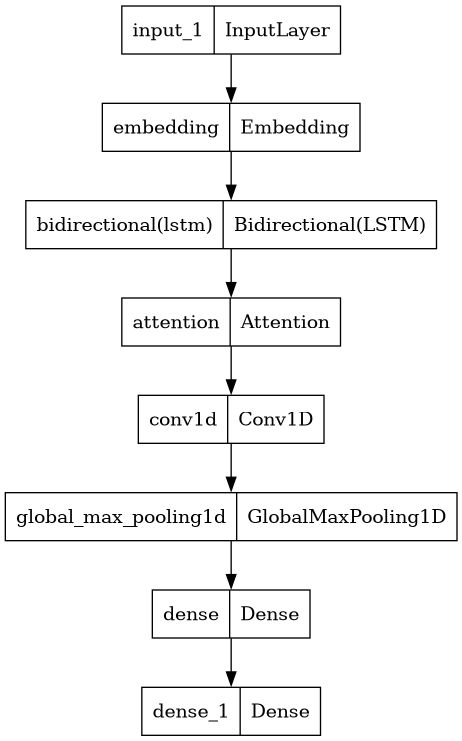

In [28]:
tf.keras.utils.plot_model(model)


In [29]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [30]:
checkpoint_path = 'training/best_model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [31]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=True)

In [32]:
#Trainig the model
history = model.fit(X_train_padded,y_train_encoded,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test_padded,y_test_encoded),
                    callbacks=[model_checkpoint_callback,early_stop])

Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 0.9111 - accuracy: 0.6351
Epoch 1: val_accuracy improved from -inf to 0.76126, saving model to training/best_model.ckpt
63/63 [==============================] - 45s 616ms/step - loss: 0.9111 - accuracy: 0.6351 - val_loss: 0.6173 - val_accuracy: 0.7613
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8446
Epoch 2: val_accuracy improved from 0.76126 to 0.87838, saving model to training/best_model.ckpt
63/63 [==============================] - 38s 598ms/step - loss: 0.4343 - accuracy: 0.8446 - val_loss: 0.3957 - val_accuracy: 0.8784
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.2384 - accuracy: 0.9238
Epoch 3: val_accuracy improved from 0.87838 to 0.91441, saving model to training/best_model.ckpt
63/63 [==============================] - 38s 600ms/step - loss: 0.2384 - accuracy: 0.9238 - val_loss: 0.2761 - val_accuracy: 0.9144
Epoch 4/20
63/63 [================

In [33]:
#Load best model
model.load_weights(checkpoint_path)

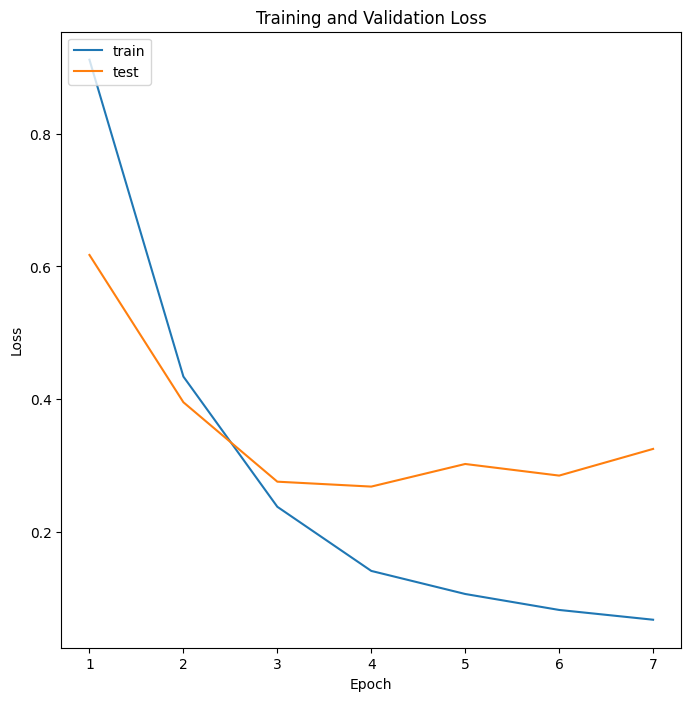

In [34]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    epochs = range(1, len(train_metric)+1)

    plt.figure(figsize=(8,8))
    plt.plot(epochs,train_metric,label = f'Training {metric}')
    plt.plot(epochs,val_metric,label = f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['train', 'test'],loc='upper left')
    plt.show()
#Training and validation loss plot
plot_metrics(history, metric='loss')

In [35]:
## Evaluate Model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

7/7 [==============================] - 0s 66ms/step - loss: 0.2853 - accuracy: 0.9234
Validation Loss: 0.285291463136673, Validation Accuracy: 0.9234234094619751


In [36]:
#prediction
y_pred = model.predict(X_test_padded)
y_pred_class = y_pred.argmax(axis=1)

7/7 [==============================] - 1s 66ms/step


In [37]:
labels=['DC','IO','RE','TD']

In [38]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_class,target_names=labels)
print(report)

              precision    recall  f1-score   support

          DC       0.89      0.80      0.84        10
          IO       0.86      0.92      0.89        59
          RE       0.95      0.95      0.95       122
          TD       0.96      0.87      0.92        31

    accuracy                           0.92       222
   macro avg       0.92      0.88      0.90       222
weighted avg       0.93      0.92      0.92       222



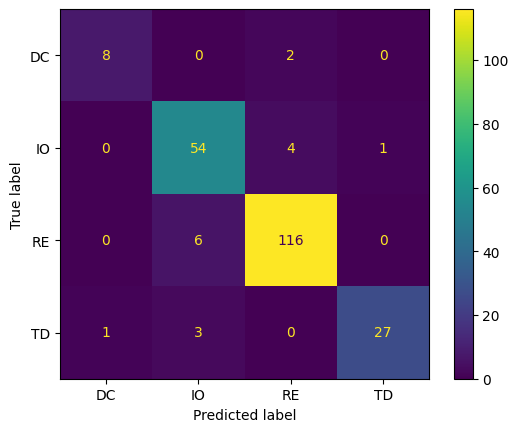

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test,y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()    

In [40]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd

# Function to plot training/validation loss using Bokeh
def plot_loss_bokeh(history):
    # Extract training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(train_loss) + 1)

    # Create a DataFrame for Bokeh
    df = pd.DataFrame({
        'epoch': epochs,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    # Create ColumnDataSource
    source = ColumnDataSource(df)

    # Create a Bokeh plot for loss
    p_loss = figure(title="Training and Validation Loss",
                    x_axis_label='Epoch', y_axis_label='Loss',
                    height=400, width=700)

    # Add lines for training and validation loss
    p_loss.line('epoch', 'train_loss', source=source, legend_label='Training Loss', line_width=2, color="blue")
    p_loss.line('epoch', 'val_loss', source=source, legend_label='Validation Loss', line_width=2, color="red")

    # Customize the plot
    p_loss.legend.location = "top_right"
    p_loss.legend.title = "Loss Type"
    p_loss.xaxis.axis_label_standoff = 12
    p_loss.yaxis.axis_label_standoff = 12

    # Show the plot for loss
    show(p_loss)

# Function to plot training/validation accuracy using Bokeh
def plot_accuracy_bokeh(history):
    # Extract training and validation accuracy
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(train_acc) + 1)

    # Create a DataFrame for Bokeh
    df = pd.DataFrame({
        'epoch': epochs,
        'train_acc': train_acc,
        'val_acc': val_acc
    })

    # Create ColumnDataSource
    source = ColumnDataSource(df)

    # Create a Bokeh plot for accuracy
    p_acc = figure(title="Training and Validation Accuracy",
                   x_axis_label='Epoch', y_axis_label='Accuracy',
                   height=400, width=700)

    # Add lines for training and validation accuracy
    p_acc.line('epoch', 'train_acc', source=source, legend_label='Training Accuracy', line_width=2, color="green", line_dash="dashed")
    p_acc.line('epoch', 'val_acc', source=source, legend_label='Validation Accuracy', line_width=2, color="orange", line_dash="dashed")

    # Customize the plot
    p_acc.legend.location = "top_right"
    p_acc.legend.title = "Accuracy Type"
    p_acc.xaxis.axis_label_standoff = 12
    p_acc.yaxis.axis_label_standoff = 12

    # Show the plot for accuracy
    show(p_acc)

# Call the functions to plot both loss and accuracy graphs separately
output_notebook()  # Display plots in Jupyter notebook
plot_loss_bokeh(history)
plot_accuracy_bokeh(history)


Loading BokehJS ...

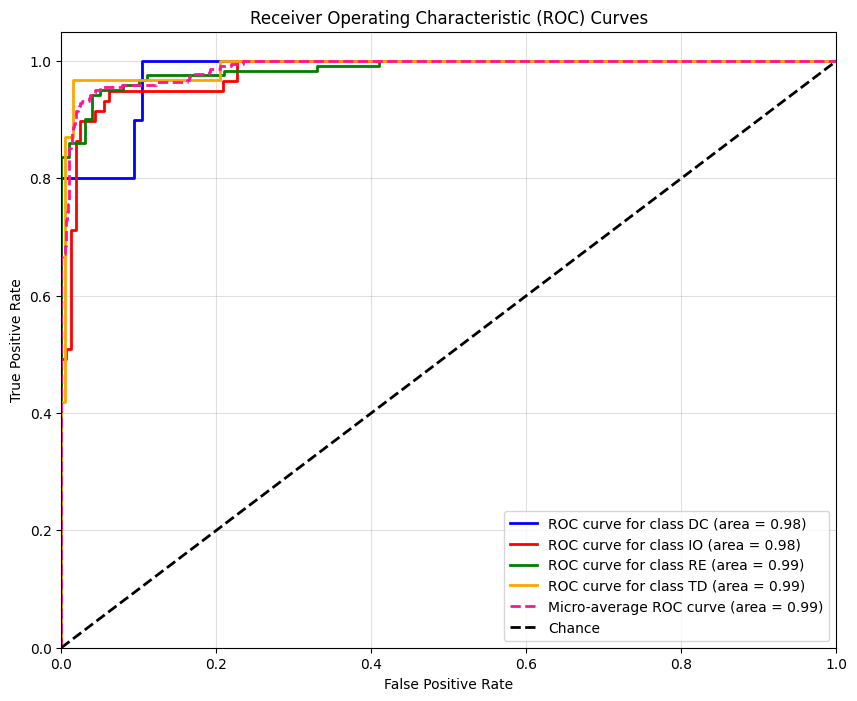

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC computation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Replace with your class indices [0, 1, 2, 3]
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {labels[i]} (area = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})')

# Plot diagonal (no-discrimination) line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.4)
plt.show()


In [42]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate the classification report
report_dict = classification_report(y_test, y_pred_class, target_names=labels, output_dict=True)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Round numerical values to 2 decimal places for better readability
report_df = report_df.round(2)

# Display the DataFrame as a neat table
print(report_df)

# If you are in a Jupyter Notebook, you can use this for a prettier display:
# from IPython.display import display
# display(report_df)


              precision  recall  f1-score  support
DC                 0.89    0.80      0.84    10.00
IO                 0.86    0.92      0.89    59.00
RE                 0.95    0.95      0.95   122.00
TD                 0.96    0.87      0.92    31.00
accuracy           0.92    0.92      0.92     0.92
macro avg          0.92    0.88      0.90   222.00
weighted avg       0.93    0.92      0.92   222.00


In [43]:
import pandas as pd
from sklearn.metrics import classification_report
from IPython.display import display

# Assuming y_test and y_pred_class are available
labels = ['DC', 'IO', 'RE', 'TD']

# Generate the classification report with output_dict=True
report = classification_report(y_test, y_pred_class, target_names=labels, output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Round values for better readability and remove trailing zeros
report_df = report_df.applymap(lambda x: f"{x:.2f}".rstrip('0').rstrip('.') if isinstance(x, float) else x)

# Style the table using pandas' Styler
styled_table = report_df.style.set_table_styles(
    [
        # Set all cells (including the index column) to light blue background, and text to black
        {'selector': 'thead th, tbody td', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('border', '2px solid black')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse')]},  # Collapse borders
        {'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('border', '2px solid black')]},  # Header specific styles
        {'selector': 'tbody th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('border', '2px solid black')]},  # Index column specific styles
    ]
)

# Display the styled table
display(styled_table)


,precision,recall,f1-score,support
DC,0.89,0.8,0.84,10
IO,0.86,0.92,0.89,59
RE,0.95,0.95,0.95,122
TD,0.96,0.87,0.92,31
accuracy,0.92,0.92,0.92,0.92
macro avg,0.92,0.88,0.9,222
weighted avg,0.93,0.92,0.92,222


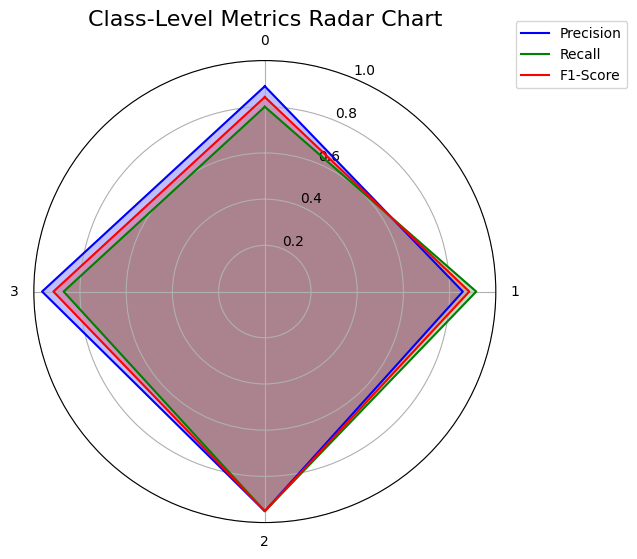

In [44]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics
precision = precision_score(y_test, y_pred_class, average=None)
recall = recall_score(y_test, y_pred_class, average=None)
f1 = f1_score(y_test, y_pred_class, average=None)
metrics = [precision, recall, f1]
labels = np.unique(y_test)  # Assuming labels are sorted

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each metric
for metric, name, color in zip(metrics, ["Precision", "Recall", "F1-Score"], ['blue', 'green', 'red']):
    values = metric.tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, label=name, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

# Add labels and legend
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)  # Assuming metrics are normalized between 0 and 1
ax.set_title("Class-Level Metrics Radar Chart", size=16)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()


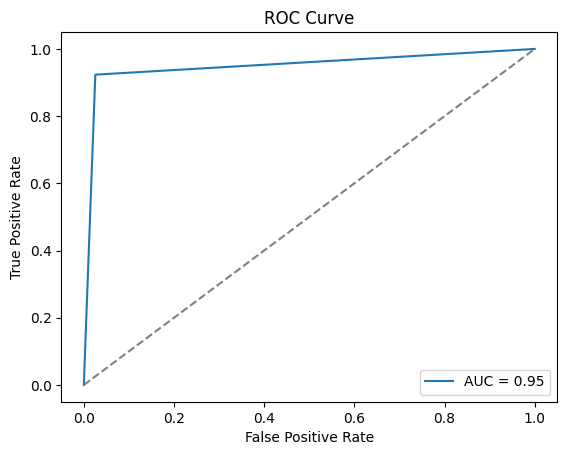

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for multi-class classification
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])  # Adjust classes as needed
y_pred_bin = label_binarize(y_pred_class, classes=[0, 1, 2, 3])

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [46]:
# Correctly identify misclassified indices
misclassified_indices = np.where(np.argmax(y_test_encoded, axis=1) != y_pred_class)[0]

# Extract misclassified samples
misclassified_samples = X_test_padded[misclassified_indices]
misclassified_true_labels = y_test_encoded[misclassified_indices]
misclassified_pred_labels = y_pred_class[misclassified_indices]

# Display the first 5 misclassified instances (or as many as available)
for i in range(min(5, len(misclassified_samples))):  # Ensure the loop doesn't exceed available samples
    print(f"Sample {i}: True label = {misclassified_true_labels[i]}, Predicted = {misclassified_pred_labels[i]}")
    print(f"Sample text: {misclassified_samples[i]}")
    print("-" * 50)


Sample 0: True label = [0. 0. 1. 0.], Predicted = 1
Sample text: [353 139   4 139   4  13  15  66   4 119  24  15   4  24 345 378   2  23
  16  72 751  25  33  36 123  17 325  20   5   5   2 247   5   2 751 154
 190 195  17 154  83 330 193  17  25 190  33 195  20   1   2 107 122 327
   2 641   2 136   1 364 189 136 189   2 136   2  60   2 832 136 364  20
   2  63   2  38   2   9  82 182 182   2  60   2   6  41   8   2   9 406
   2   6 141   8   2  16  72   9 345   8 846 653   2 863   2  72   6 323
   2   9 483   2 193   2  17   2 389   2   6 611   2   9 327   2  82 182
 189   2]
--------------------------------------------------
Sample 1: True label = [0. 0. 1. 0.], Predicted = 1
Sample text: [909  68   4 253   5 164   5  24  68   4  13  15  66   4 119  24  15 205
  31 178  24   4  24 400  68 261 274 225  19 157 322 372 322 261  15 157
 225   6 261 274  15 372 225  19 274  52 153   7  11   7 222   3  11   7
  11 162   7  11   7  11 149   7 117   7 150   7  11   7  96  11  86  17
  44  

# Transformer Model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 128)          5820160   
                                                                 
 transformer_block (Transfo  (None, 128, 128)          593920    
 rmerBlock)                                                      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 4)                 516 

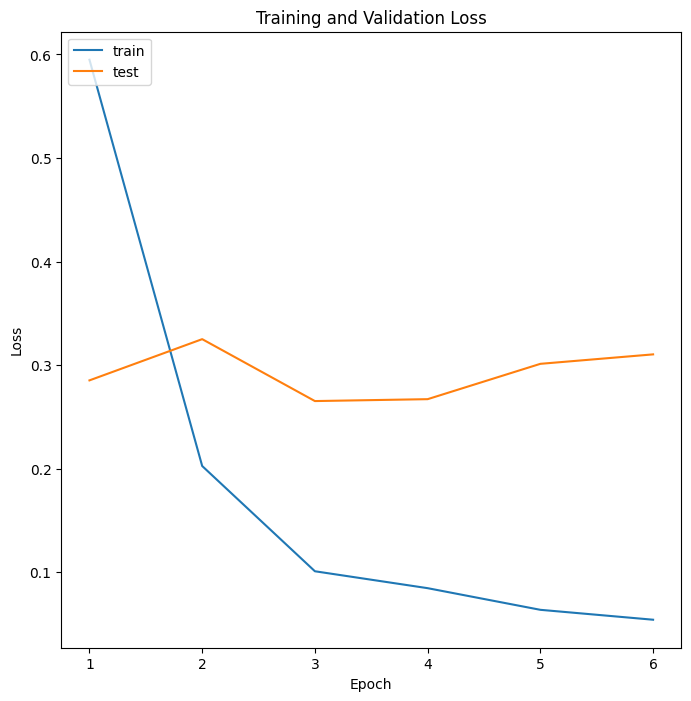

7/7 [==============================] - 1s 159ms/step - loss: 0.2671 - accuracy: 0.9324
Validation Loss: 0.2670544683933258, Validation Accuracy: 0.9324324131011963
7/7 [==============================] - 1s 164ms/step
              precision    recall  f1-score   support

          DC       0.89      0.80      0.84        10
          IO       0.84      0.97      0.90        59
          RE       0.98      0.95      0.97       122
          TD       0.96      0.84      0.90        31

    accuracy                           0.93       222
   macro avg       0.92      0.89      0.90       222
weighted avg       0.94      0.93      0.93       222



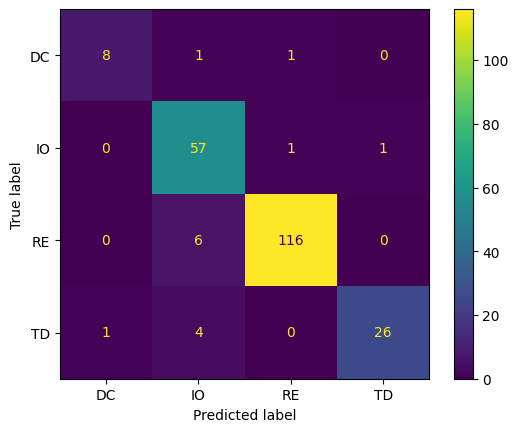

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalMaxPooling1D
from tensorflow.keras.models import Model

# Input layer
input_layer = Input(shape=(128,))  # Specify max_len as the maximum sequence length

# Embedding layer
embedding_layer = Embedding(emb_len, 128)(input_layer)

# Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embedding_layer.shape[-1])
        ])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Adding Transformer block
transformer_block = TransformerBlock(num_heads=8, key_dim=128, ff_dim=256)(embedding_layer)

# Global Max Pooling
global_max_pooling_layer = GlobalMaxPooling1D()(transformer_block)

# Dense layers
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)

# Output layer
output_layer = Dense(4, activation='softmax')(dense_layer_1)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

# Model summary
model.summary()
tf.keras.utils.plot_model(model)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Checkpoint and EarlyStopping callbacks
checkpoint_path = 'training/best_model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=True)

# Training the model
history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test_padded, y_test_encoded),
                    callbacks=[model_checkpoint_callback, early_stop])

# Load best model
model.load_weights(checkpoint_path)

# Function to plot training/validation metrics
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    epochs = range(1, len(train_metric)+1)

    plt.figure(figsize=(8,8))
    plt.plot(epochs, train_metric, label=f'Training {metric}')
    plt.plot(epochs, val_metric, label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Training and validation loss plot
plot_metrics(history, metric='loss')

# Evaluate Model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

# Prediction
y_pred = model.predict(X_test_padded)
y_pred_class = y_pred.argmax(axis=1)

# Classification report
labels = ['DC', 'IO', 'RE', 'TD']
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_class, target_names=labels)
print(report)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()




Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 128)          5820160   
                                                                 
 positional_encoding (Posit  (None, 128, 128)          16384     
 ionalEncoding)                                                  
                                                                 
 multi_scale_transformer_bl  (None, 128, 128)          725888    
 ock (MultiScaleTransformer                                      
 Block)                                                          
                                                                 
 se_block (SEBlock)          (None, 128, 128)          2184      
                                                           

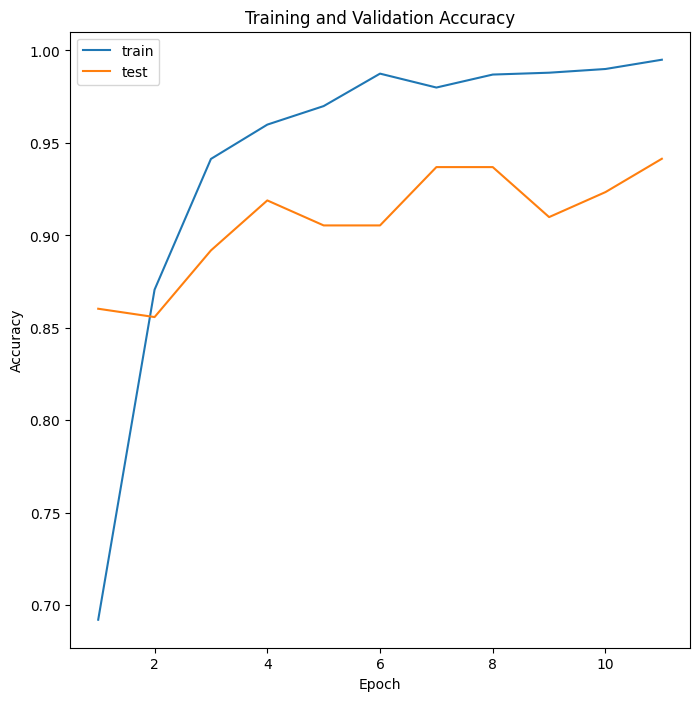

7/7 [==============================] - 1s 172ms/step - loss: 0.2910 - accuracy: 0.9414
Validation Loss: 0.29096540808677673, Validation Accuracy: 0.9414414167404175
7/7 [==============================] - 1s 169ms/step
              precision    recall  f1-score   support

          DC       1.00      0.80      0.89        10
          IO       0.86      0.97      0.91        59
          RE       0.97      0.96      0.97       122
          TD       0.96      0.87      0.92        31

    accuracy                           0.94       222
   macro avg       0.95      0.90      0.92       222
weighted avg       0.95      0.94      0.94       222



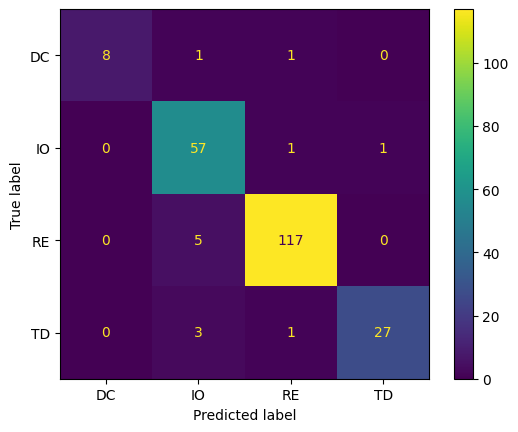

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalMaxPooling1D, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

# Input layer
input_layer = Input(shape=(128,))  # Specify max_len as the maximum sequence length

# Positional Encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_embedding = Embedding(input_dim=max_len, output_dim=d_model)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        return inputs + self.pos_embedding(positions)

# Embedding layer
embedding_layer = Embedding(input_dim=emb_len, output_dim=128)(input_layer)
positional_encoding = PositionalEncoding(max_len=128, d_model=128)(embedding_layer)

# Transformer block with Multi-Scale Attention
class MultiScaleTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout_rate=0.1):
        super(MultiScaleTransformerBlock, self).__init__()
        self.attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.attn2 = MultiHeadAttention(num_heads=num_heads // 2, key_dim=key_dim // 2)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output1 = self.attn1(inputs, inputs)
        attn_output2 = self.attn2(inputs, inputs)
        attn_output = Add()([attn_output1, attn_output2])
        attn_output = self.dropout(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Adding Multi-Scale Transformer block
transformer_block = MultiScaleTransformerBlock(num_heads=8, key_dim=128, ff_dim=256)(positional_encoding)

# Squeeze-and-Excitation block
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, reduction=16):
        super(SEBlock, self).__init__()
        self.global_pool = GlobalMaxPooling1D()
        self.dense1 = Dense(128 // reduction, activation='relu')
        self.dense2 = Dense(128, activation='sigmoid')

    def call(self, inputs):
        se_output = self.global_pool(inputs)
        se_output = self.dense1(se_output)
        se_output = self.dense2(se_output)
        return tf.multiply(inputs, tf.expand_dims(se_output, axis=1))

se_block = SEBlock()(transformer_block)

# Global Max Pooling
global_max_pooling_layer = GlobalMaxPooling1D()(se_block)

# Dense layers with Adaptive Dropout
adaptive_dropout_rate = 0.2
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)
dropout_layer = Dropout(adaptive_dropout_rate)(dense_layer_1)

# Output layer
output_layer = Dense(4, activation='softmax')(dropout_layer)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

# Model summary
model.summary()

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
checkpoint_path = 'training/best_model.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Training the model
history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test_padded, y_test_encoded),
                    callbacks=[model_checkpoint_callback, early_stop, reduce_lr])

# Load best model
model.load_weights(checkpoint_path)

# Plot metrics
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    epochs = range(1, len(train_metric)+1)

    plt.figure(figsize=(8,8))
    plt.plot(epochs, train_metric, label=f'Training {metric}')
    plt.plot(epochs, val_metric, label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_metrics(history, 'accuracy')

# Evaluate and predict
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

y_pred = model.predict(X_test_padded)
y_pred_class = y_pred.argmax(axis=1)

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['DC', 'IO', 'RE', 'TD']
report = classification_report(y_test, y_pred_class, target_names=labels)
print(report)

cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()


In [49]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd

# Function to plot training/validation loss using Bokeh
def plot_loss_bokeh(history):
    # Extract training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(train_loss) + 1)

    # Create a DataFrame for Bokeh
    df = pd.DataFrame({
        'epoch': epochs,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    # Create ColumnDataSource
    source = ColumnDataSource(df)

    # Create a Bokeh plot for loss
    p_loss = figure(title="Training and Validation Loss",
                    x_axis_label='Epoch', y_axis_label='Loss',
                    height=400, width=700)

    # Add lines for training and validation loss
    p_loss.line('epoch', 'train_loss', source=source, legend_label='Training Loss', line_width=2, color="blue")
    p_loss.line('epoch', 'val_loss', source=source, legend_label='Validation Loss', line_width=2, color="red")

    # Customize the plot
    p_loss.legend.location = "top_right"
    p_loss.legend.title = "Loss Type"
    p_loss.xaxis.axis_label_standoff = 12
    p_loss.yaxis.axis_label_standoff = 12

    # Show the plot for loss
    show(p_loss)

# Function to plot training/validation accuracy using Bokeh
def plot_accuracy_bokeh(history):
    # Extract training and validation accuracy
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(train_acc) + 1)

    # Create a DataFrame for Bokeh
    df = pd.DataFrame({
        'epoch': epochs,
        'train_acc': train_acc,
        'val_acc': val_acc
    })

    # Create ColumnDataSource
    source = ColumnDataSource(df)

    # Create a Bokeh plot for accuracy
    p_acc = figure(title="Training and Validation Accuracy",
                   x_axis_label='Epoch', y_axis_label='Accuracy',
                   height=400, width=700)

    # Add lines for training and validation accuracy
    p_acc.line('epoch', 'train_acc', source=source, legend_label='Training Accuracy', line_width=2, color="green", line_dash="dashed")
    p_acc.line('epoch', 'val_acc', source=source, legend_label='Validation Accuracy', line_width=2, color="orange", line_dash="dashed")

    # Customize the plot
    p_acc.legend.location = "top_right"
    p_acc.legend.title = "Accuracy Type"
    p_acc.xaxis.axis_label_standoff = 12
    p_acc.yaxis.axis_label_standoff = 12

    # Show the plot for accuracy
    show(p_acc)

# Call the functions to plot both loss and accuracy graphs separately
output_notebook()  # Display plots in Jupyter notebook
plot_loss_bokeh(history)
plot_accuracy_bokeh(history)


Loading BokehJS ...

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 128, 128)          5820160   
                                                                 
 positional_encoding_1 (Pos  (None, 128, 128)          16384     
 itionalEncoding)                                                
                                                                 
 cnn_transformer_block (CNN  (None, 64, 128)           775168    
 TransformerBlock)                                               
                                                                 
 se_block_1 (SEBlock)        (None, 64, 128)           2184      
                                                                 
 global_max_pooling1d_5 (Gl  (None, 128)               0   

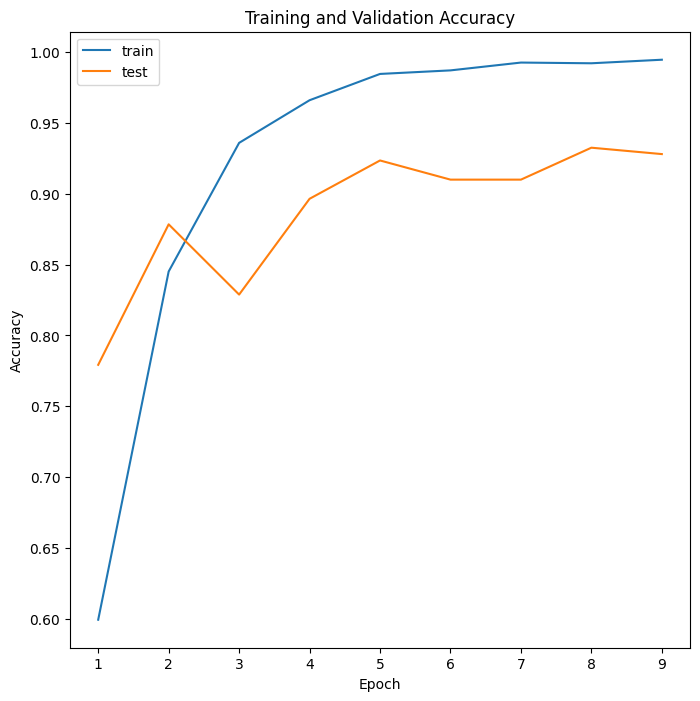

7/7 [==============================] - 1s 71ms/step - loss: 0.2906 - accuracy: 0.9324
Validation Loss: 0.2906073033809662, Validation Accuracy: 0.9324324131011963
7/7 [==============================] - 1s 68ms/step
              precision    recall  f1-score   support

          DC       1.00      0.60      0.75        10
          IO       0.93      0.93      0.93        59
          RE       0.93      0.98      0.95       122
          TD       0.93      0.87      0.90        31

    accuracy                           0.93       222
   macro avg       0.95      0.84      0.88       222
weighted avg       0.93      0.93      0.93       222



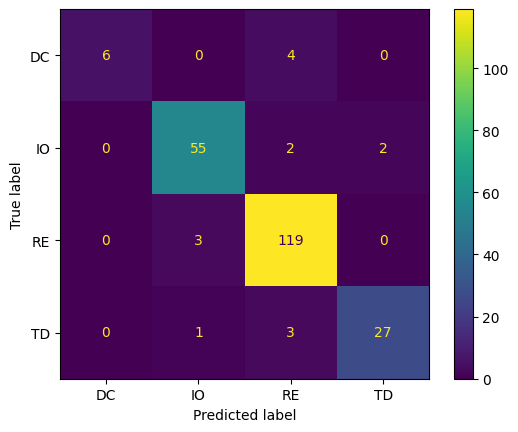

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, GlobalMaxPooling1D, Add, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

# Input layer
input_layer = Input(shape=(128,))  # Specify max_len as the maximum sequence length

# Positional Encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_embedding = Embedding(input_dim=max_len, output_dim=d_model)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        return inputs + self.pos_embedding(positions)

# Embedding layer
embedding_layer = Embedding(input_dim=emb_len, output_dim=128)(input_layer)
positional_encoding = PositionalEncoding(max_len=128, d_model=128)(embedding_layer)

# Hybrid CNN-Transformer block with Multi-Scale Attention
class CNNTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout_rate=0.1):
        super(CNNTransformerBlock, self).__init__()
        self.conv1 = Conv1D(128, 3, activation='relu', padding='same')  # CNN layer for local feature extraction
        self.pool1 = MaxPooling1D(pool_size=2)  # Pooling layer to reduce dimensionality
        self.attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.attn2 = MultiHeadAttention(num_heads=num_heads // 2, key_dim=key_dim // 2)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        cnn_output = self.conv1(inputs)
        cnn_output = self.pool1(cnn_output)  # Downsample the CNN output
        
        # Apply MultiHead Attention
        attn_output1 = self.attn1(cnn_output, cnn_output)
        attn_output2 = self.attn2(cnn_output, cnn_output)
        attn_output = Add()([attn_output1, attn_output2])
        attn_output = self.dropout(attn_output, training=training)
        out1 = self.layernorm1(cnn_output + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Adding CNN-Transformer block
cnn_transformer_block = CNNTransformerBlock(num_heads=8, key_dim=128, ff_dim=256)(positional_encoding)

# Squeeze-and-Excitation block
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, reduction=16):
        super(SEBlock, self).__init__()
        self.global_pool = GlobalMaxPooling1D()
        self.dense1 = Dense(128 // reduction, activation='relu')
        self.dense2 = Dense(128, activation='sigmoid')

    def call(self, inputs):
        se_output = self.global_pool(inputs)
        se_output = self.dense1(se_output)
        se_output = self.dense2(se_output)
        return tf.multiply(inputs, tf.expand_dims(se_output, axis=1))

se_block = SEBlock()(cnn_transformer_block)

# Global Max Pooling
global_max_pooling_layer = GlobalMaxPooling1D()(se_block)

# Dense layers with Adaptive Dropout
adaptive_dropout_rate = 0.2
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)
dropout_layer = Dropout(adaptive_dropout_rate)(dense_layer_1)

# Output layer
output_layer = Dense(4, activation='softmax')(dropout_layer)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

# Model summary
model.summary()

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
checkpoint_path = 'training/best_model.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Training the model
history = model.fit(X_train_padded, y_train_encoded,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test_padded, y_test_encoded),
                    callbacks=[model_checkpoint_callback, early_stop, reduce_lr])

# Load best model
model.load_weights(checkpoint_path)

# Plot metrics
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    epochs = range(1, len(train_metric)+1)

    plt.figure(figsize=(8,8))
    plt.plot(epochs, train_metric, label=f'Training {metric}')
    plt.plot(epochs, val_metric, label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_metrics(history, 'accuracy')

# Evaluate and predict
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

y_pred = model.predict(X_test_padded)
y_pred_class = y_pred.argmax(axis=1)

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['DC', 'IO', 'RE', 'TD']
report = classification_report(y_test, y_pred_class, target_names=labels)
print(report)

cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Embedding, Dropout, Dense, GlobalMaxPooling1D, Conv1D, LayerNormalization
)
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.layers import MultiHeadAttention, Add

# Parameters
vocab_size = 10000  # Size of the vocabulary
embedding_dim = 128  # Dimensions of the embedding
max_sequence_length = 128  # Maximum length of sequences
num_classes = 4  # Number of output classes

# Generate Dummy Dataset
X_train_padded = np.random.randint(0, vocab_size, size=(1000, max_sequence_length))
X_test_padded = np.random.randint(0, vocab_size, size=(200, max_sequence_length))
y_train_encoded = tf.keras.utils.to_categorical(np.random.randint(0, num_classes, size=(1000,)), num_classes=num_classes)
y_test_encoded = tf.keras.utils.to_categorical(np.random.randint(0, num_classes, size=(200,)), num_classes=num_classes)

# Define Transformer Block
def transformer_block(inputs, num_heads, ff_dim, dropout_rate=0.1):
    """Transformer block with Multi-Head Attention and Feed-Forward Neural Network."""
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Add residual connection
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed-Forward Neural Network
    ffn = Dense(ff_dim, activation="relu")(attention_output)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn_output = Dropout(dropout_rate)(ffn)
    ffn_output = Add()([attention_output, ffn_output])  # Add residual connection
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)

    return ffn_output

# Model Architecture
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)

# CNN Layer
cnn_output = Conv1D(128, kernel_size=3, activation='relu', padding='same')(embedding_layer)
cnn_output = GlobalMaxPooling1D()(cnn_output)

# Transformer Layer
transformer_output = transformer_block(embedding_layer, num_heads=4, ff_dim=128)

# Combine CNN and Transformer Outputs
combined_output = tf.keras.layers.Concatenate()([cnn_output, transformer_output[:, 0, :]])  # Use the first token from Transformer

# Dense Layers (Classification Head)
dense_1 = Dense(128, activation='relu')(combined_output)
dropout = Dropout(0.2)(dense_1)
output_layer = Dense(num_classes, activation='softmax')(dropout)

# Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display Model Summary
model.summary()

# Train the Model
history = model.fit(
    X_train_padded,
    y_train_encoded,
    batch_size=64,
    epochs=10,
    validation_data=(X_test_padded, y_test_encoded),
    verbose=1,
)

# Evaluate the Model
y_pred = model.predict(X_test_padded, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class indices
y_true_classes = np.argmax(y_test_encoded, axis=1)  # True class indices

# Metrics
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes))


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 128, 128)             1280000   ['input_9[0][0]']             
                                                                                                  
 multi_head_attention_9 (Mu  (None, 128, 128)             263808    ['embedding_12[0][0]',        
 ltiHeadAttention)                                                   'embedding_12[0][0]']        
                                                                                                  
 dropout_15 (Dropout)        (None, 128, 128)             0         ['multi_head_attention_

7/7 [==============================] - 0s 67ms/step


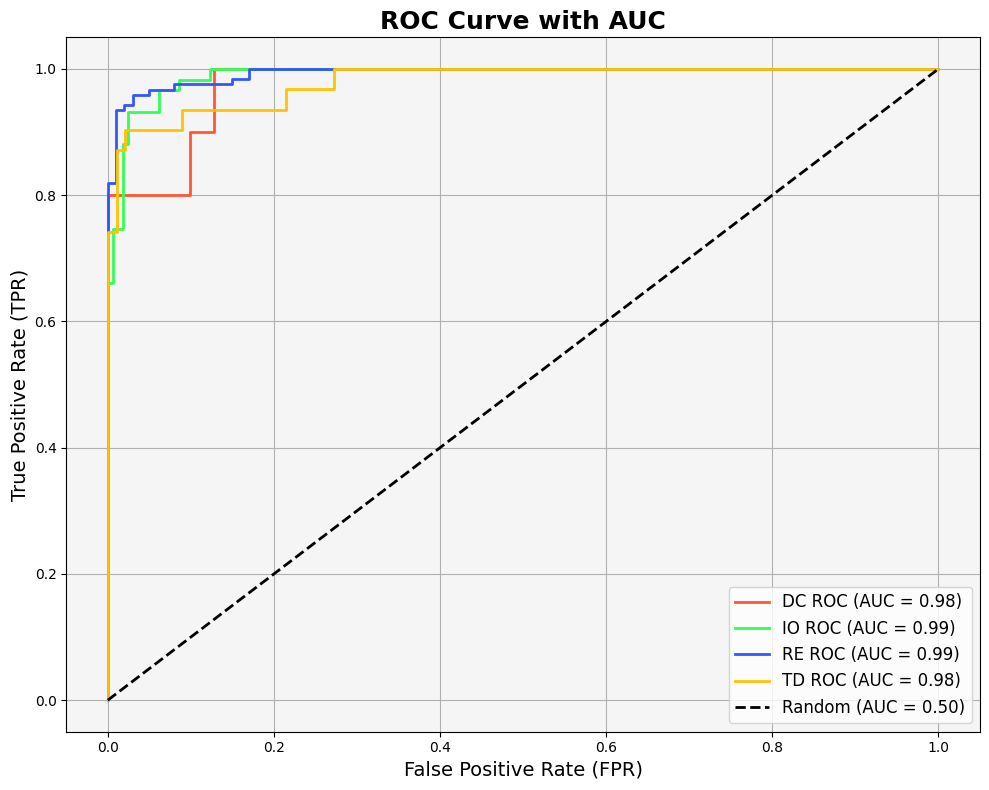

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import label_binarize

# Assuming you have y_test_encoded (one-hot encoded) and y_pred from the model
# Get predicted probabilities for each class
y_pred = model.predict(X_test_padded)  # This should be your predicted probabilities

# If the labels are not one-hot encoded, you should binarize them
y_test_encoded = label_binarize(y_test, classes=[0, 1, 2, 3])

# Calculate ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Loop through each class
for i in range(4):  # Since there are 4 classes
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

# Set a color palette
colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300']

for i, label in enumerate(['DC', 'IO', 'RE', 'TD']):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'{label} ROC (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal (random guess line) with a dashed line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2, label='Random (AUC = 0.50)')

# Add a title, labels, and legend
plt.title('ROC Curve with AUC', fontsize=18, fontweight='bold')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Customize the plot appearance
plt.grid(True)
plt.gca().set_facecolor('#F5F5F5')  # Optional background color for the plot

# Display the plot
plt.tight_layout()
plt.show()



In [52]:
import pandas as pd
from sklearn.metrics import classification_report
from IPython.display import display

# Assuming `y_test` and `y_pred_class` are available
labels = ['DC', 'IO', 'RE', 'TD']
report = classification_report(y_test, y_pred_class, target_names=labels, output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Round values for better readability and remove trailing zeros
report_df = report_df.applymap(lambda x: f"{x:.2f}".rstrip('0').rstrip('.') if isinstance(x, float) else x)

# Style the table using pandas' Styler
styled_table = report_df.style.set_table_styles(
    [
        # Set all cells (including the index column) to light blue background, and text to black
        {'selector': 'thead th, tbody td', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('border', '2px solid black')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse')]},  # Collapse borders
        {'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('border', '2px solid black')]},  # Header specific styles
        {'selector': 'tbody th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('border', '2px solid black')]},  # Index column specific styles
    ]
)

# Display the styled table
display(styled_table)


,precision,recall,f1-score,support
DC,1,0.6,0.75,10
IO,0.93,0.93,0.93,59
RE,0.93,0.98,0.95,122
TD,0.93,0.87,0.9,31
accuracy,0.93,0.93,0.93,0.93
macro avg,0.95,0.84,0.88,222
weighted avg,0.93,0.93,0.93,222


              precision    recall  f1-score     support
DC             1.000000  0.600000  0.750000   10.000000
IO             0.932203  0.932203  0.932203   59.000000
RE             0.929688  0.975410  0.952000  122.000000
TD             0.931034  0.870968  0.900000   31.000000
accuracy       0.932432  0.932432  0.932432    0.932432
macro avg      0.948231  0.844645  0.883551  222.000000
weighted avg   0.933711  0.932432  0.930378  222.000000


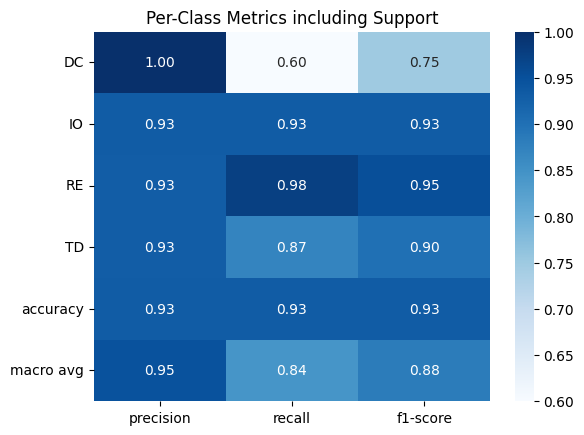

In [53]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test, y_pred_class, and labels are already defined
report_dict = classification_report(y_test, y_pred_class, target_names=labels, output_dict=True)

# Convert the report to a DataFrame
metrics_df = pd.DataFrame(report_dict).transpose()

# Print the metrics DataFrame
print(metrics_df)

# Optionally visualize it as a heatmap
sns.heatmap(metrics_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")

# Include 'support' as well in the heatmap
plt.title('Per-Class Metrics including Support')
plt.show()


7/7 [==============================] - 1s 67ms/step


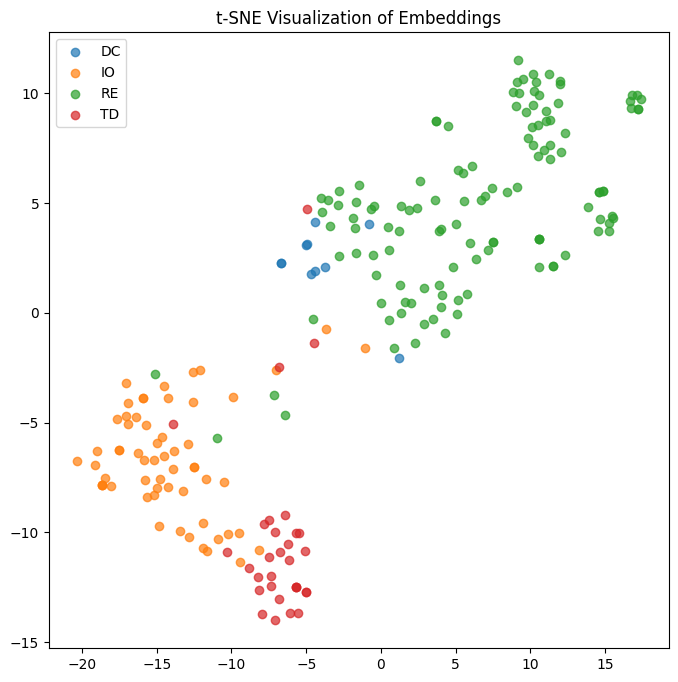

In [54]:
from sklearn.manifold import TSNE

# Extract embeddings
embedding_model = Model(inputs=model.input, outputs=model.layers[-3].output)  # Get penultimate layer
embeddings = embedding_model.predict(X_test_padded)

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 8))
for i, label in enumerate(labels):
    idx = (y_test == i)
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=label, alpha=0.7)
plt.title('t-SNE Visualization of Embeddings')
plt.legend()
plt.show()


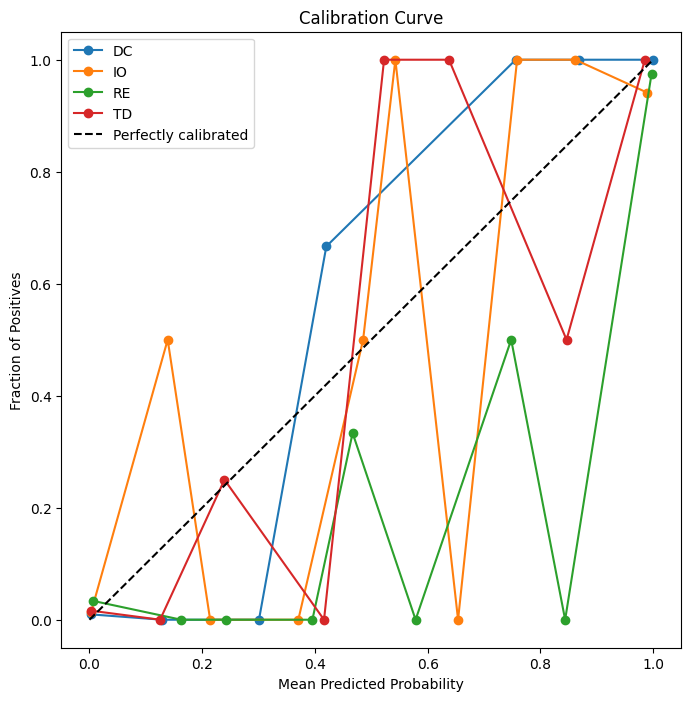

In [55]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 8))
for i, label in enumerate(labels):
    prob_true, prob_pred = calibration_curve((y_test == i).astype(int), y_pred[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=label)

plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.title("Calibration Curve")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.show()


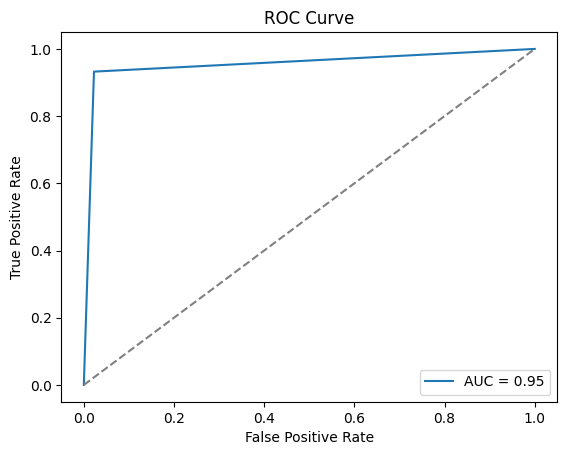

In [56]:
# Binarize the output for multi-class classification
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])  # Adjust classes as needed
y_pred_bin = label_binarize(y_pred_class, classes=[0, 1, 2, 3])

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [57]:
# Correctly identify misclassified indices
misclassified_indices = np.where(np.argmax(y_test_encoded, axis=1) != y_pred_class)[0]

# Extract misclassified samples
misclassified_samples = X_test_padded[misclassified_indices]
misclassified_true_labels = y_test_encoded[misclassified_indices]
misclassified_pred_labels = y_pred_class[misclassified_indices]

# Display the first 5 misclassified instances (or as many as available)
for i in range(min(5, len(misclassified_samples))):  # Ensure the loop doesn't exceed available samples
    print(f"Sample {i}: True label = {misclassified_true_labels[i]}, Predicted = {misclassified_pred_labels[i]}")
    print(f"Sample text: {misclassified_samples[i]}")
    print("-" * 50)


Sample 0: True label = [0 0 0 1], Predicted = 2
Sample text: [    1  4048     3     1    18     1   181     1  1411  1037     4 22208
   184    15    13     4    13 22209     4    13   142   142 22210    13
     4  8760    12    56    10     1   171 12474 12475 12476 12477    18
 22211     1  7475   160  7475   181    10   480 41577  4641 22212 22213
 22214  1037    13    12     1   171 12474 12475 12476 12477  5445 15304
  8760    15 22215 22216    12 15305     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
--------------------------------------------------
Sample 1: True label = [0 0 1 0], Predicted = 1
Sample text: [353 139   4 139   4  13  15  66   4 119  24  1

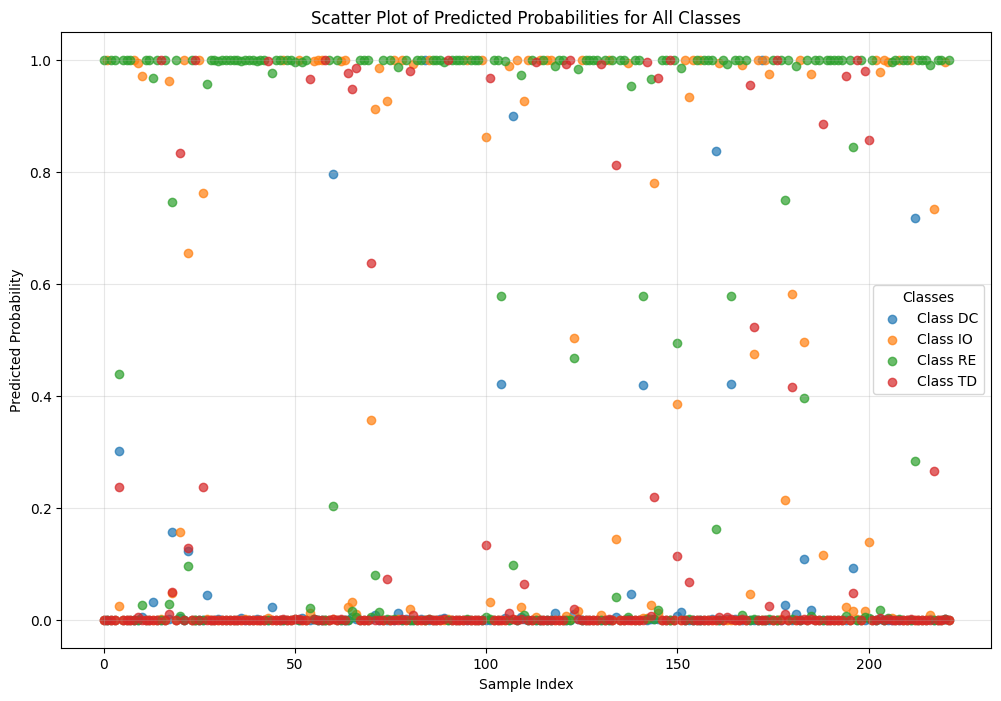

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Scatter plot for all classes in a single graph
plt.figure(figsize=(12, 8))

for class_idx, class_label in enumerate(labels):
    # Binary representation for the current class's true labels
    true_labels = (np.array(y_test) == class_idx).astype(int)  # Binary: 1 if the sample belongs to this class, 0 otherwise
    predicted_probs = y_pred[:, class_idx]  # Predicted probabilities for this class

    # Scatter plot for the current class
    plt.scatter(
        range(len(predicted_probs)), 
        predicted_probs, 
        label=f'Class {class_label}', 
        alpha=0.7
    )

# Add plot details
plt.title('Scatter Plot of Predicted Probabilities for All Classes')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.legend(title='Classes')
plt.grid(alpha=0.3)
plt.show()


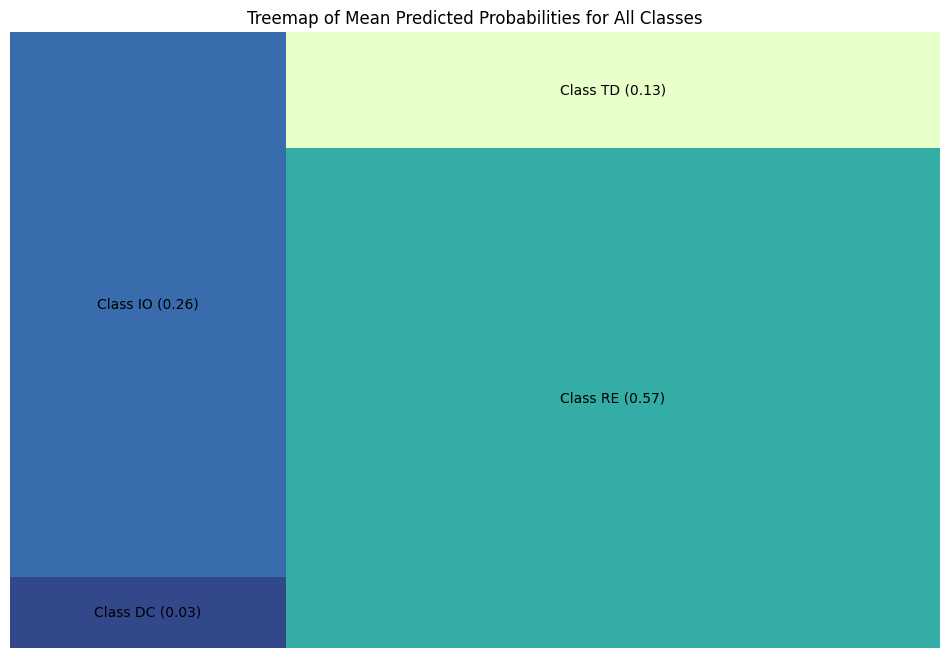

In [59]:
import squarify
import numpy as np
import matplotlib.pyplot as plt

# Define the custom colors you want to use
custom_colors = ['#001A6E', '#074799', '#009990', '#E1FFBB']

# Calculate the mean predicted probabilities for each class
class_means = np.mean(y_pred, axis=0)

# Create a treemap
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=class_means,
    label=[f"Class {label} ({mean:.2f})" for label, mean in zip(labels, class_means)],
    color=custom_colors[:len(labels)],  # Use the custom colors list
    alpha=0.8
)

# Add plot details
plt.title('Treemap of Mean Predicted Probabilities for All Classes')
plt.axis('off')
plt.show()


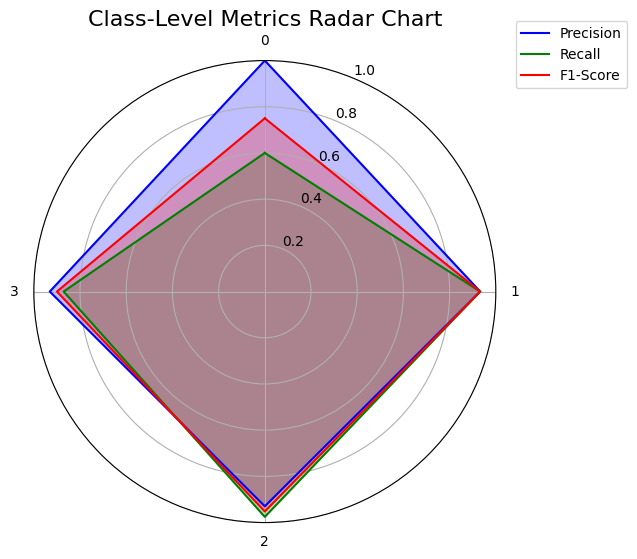

In [60]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics
precision = precision_score(y_test, y_pred_class, average=None)
recall = recall_score(y_test, y_pred_class, average=None)
f1 = f1_score(y_test, y_pred_class, average=None)
metrics = [precision, recall, f1]
labels = np.unique(y_test)  # Assuming labels are sorted

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each metric
for metric, name, color in zip(metrics, ["Precision", "Recall", "F1-Score"], ['blue', 'green', 'red']):
    values = metric.tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, label=name, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

# Add labels and legend
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)  # Assuming metrics are normalized between 0 and 1
ax.set_title("Class-Level Metrics Radar Chart", size=16)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()


1/1 [==============================] - 0s 328ms/step


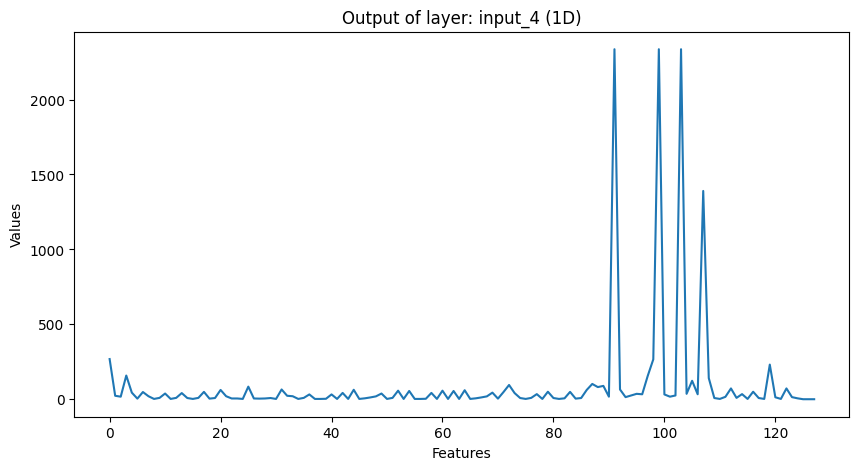

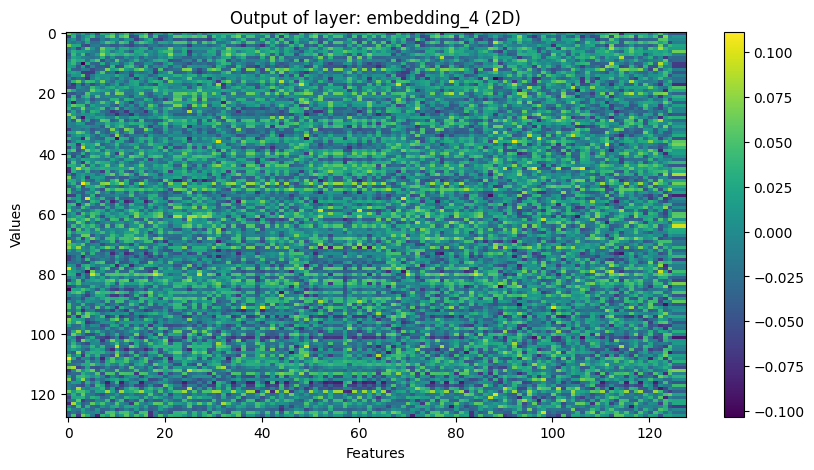

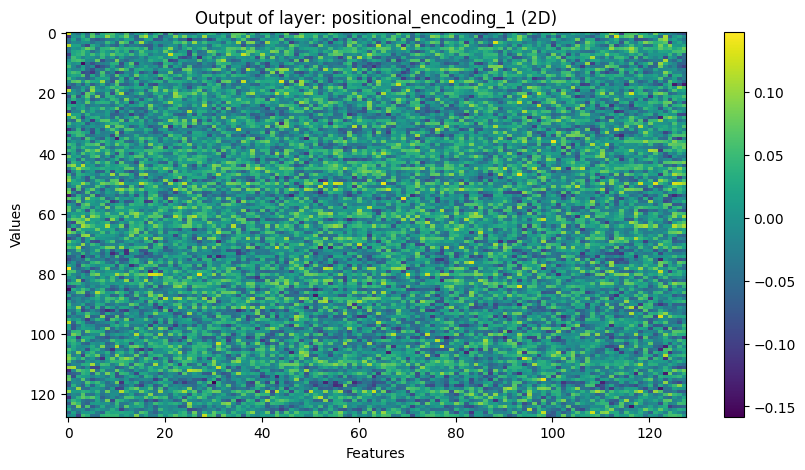

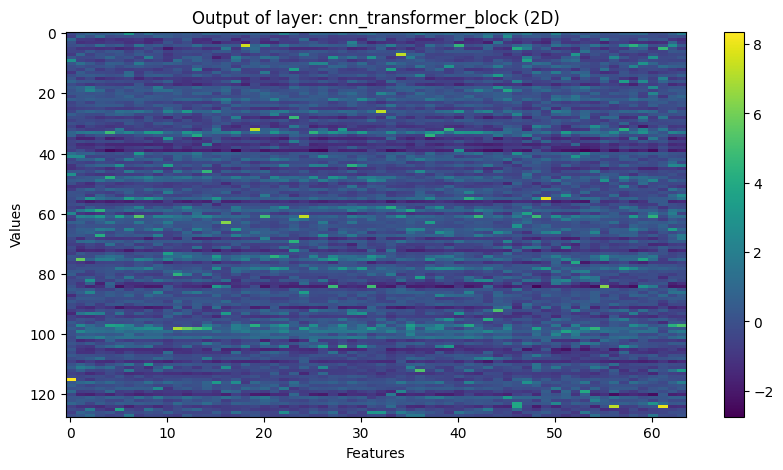

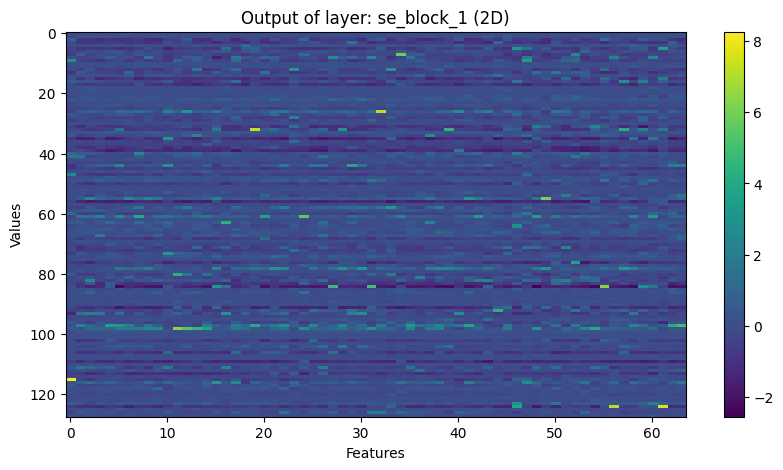

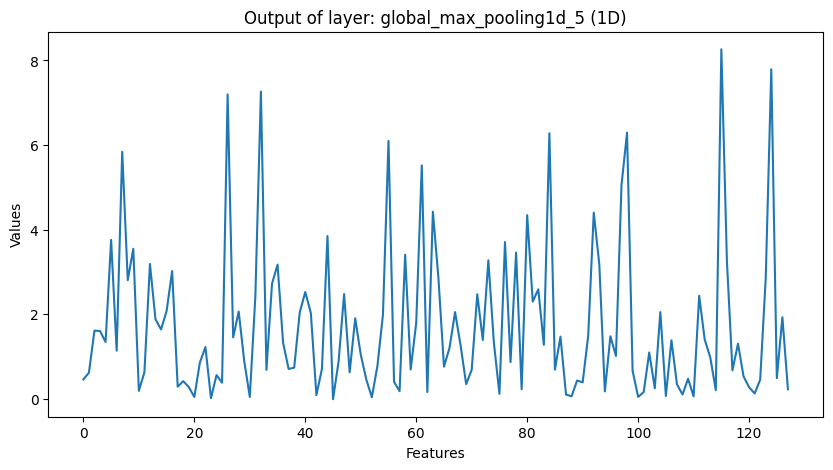

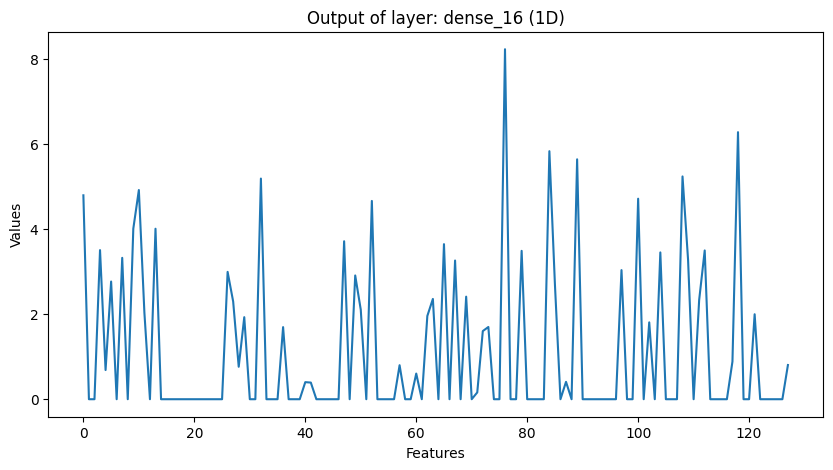

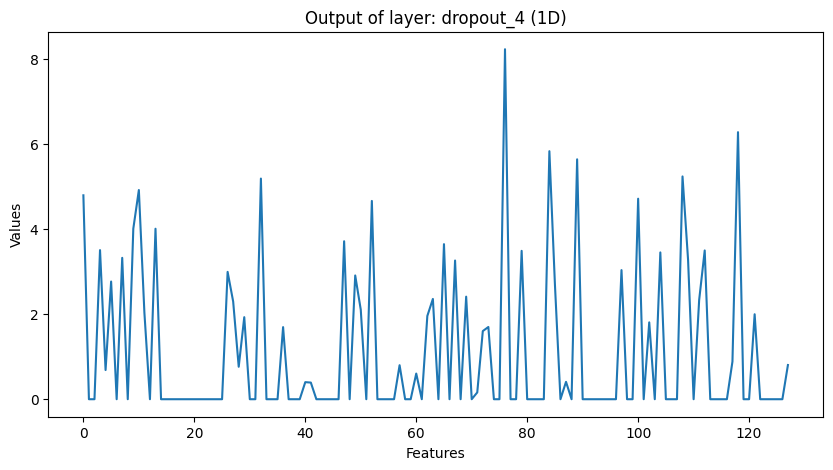

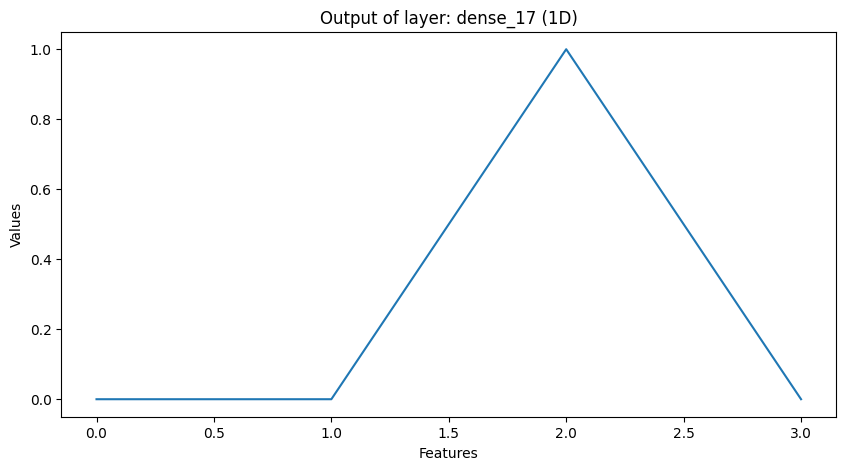

In [61]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Create a new model that outputs intermediate layers
layer_outputs = [layer.output for layer in model.layers]  # Extract outputs from each layer
visualization_model = Model(inputs=model.input, outputs=layer_outputs)

# Choose a random sample from test data
sample_input = X_test_padded[0:1]  # Single input for visualization
intermediate_outputs = visualization_model.predict(sample_input)

# Function to visualize intermediate outputs
def visualize_intermediate_outputs(intermediate_outputs, layer_names):
    for idx, intermediate_output in enumerate(intermediate_outputs):
        output = np.squeeze(intermediate_output)  # Remove batch dimension
        layer_name = layer_names[idx]
        plt.figure(figsize=(10, 5))
        if len(output.shape) == 1:  # Dense layers
            plt.plot(output)
            plt.title(f'Output of layer: {layer_name} (1D)')
        elif len(output.shape) == 2:  # Embedding or 2D layers
            plt.imshow(output.T, aspect='auto', cmap='viridis')
            plt.title(f'Output of layer: {layer_name} (2D)')
            plt.colorbar()
        elif len(output.shape) == 3:  # Attention or 3D layers
            plt.imshow(output[0], aspect='auto', cmap='viridis')
            plt.title(f'Output of layer: {layer_name} (3D)')
            plt.colorbar()
        plt.xlabel('Features')
        plt.ylabel('Values')
        plt.show()

# Visualize the outputs of each layer
layer_names = [layer.name for layer in model.layers]
visualize_intermediate_outputs(intermediate_outputs, layer_names)


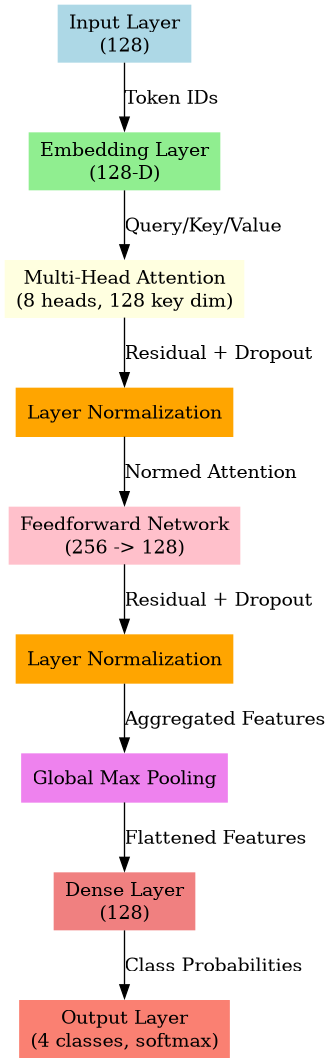

In [62]:
from graphviz import Digraph
from IPython.display import Image, display

def create_model_diagram():
    dot = Digraph(format="png", engine="dot")
    dot.attr(rankdir="TB", splines="ortho", concentrate="true")

    # Input Node
    dot.node("Input", "Input Layer\n(128)", shape="box", style="filled", color="lightblue")

    # Embedding Node
    dot.node("Embedding", "Embedding Layer\n(128-D)", shape="box", style="filled", color="lightgreen")
    dot.edge("Input", "Embedding", label="Token IDs")

    # Transformer Block
    dot.node("Attention", "Multi-Head Attention\n(8 heads, 128 key dim)", shape="box", style="filled", color="lightyellow")
    dot.node("Norm1", "Layer Normalization", shape="box", style="filled", color="orange")
    dot.node("FFN", "Feedforward Network\n(256 -> 128)", shape="box", style="filled", color="pink")
    dot.node("Norm2", "Layer Normalization", shape="box", style="filled", color="orange")
    dot.edge("Embedding", "Attention", label="Query/Key/Value")
    dot.edge("Attention", "Norm1", label="Residual + Dropout")
    dot.edge("Norm1", "FFN", label="Normed Attention")
    dot.edge("FFN", "Norm2", label="Residual + Dropout")
    
    # Global Max Pooling
    dot.node("Pooling", "Global Max Pooling", shape="box", style="filled", color="violet")
    dot.edge("Norm2", "Pooling", label="Aggregated Features")

    # Dense Layers
    dot.node("Dense1", "Dense Layer\n(128)", shape="box", style="filled", color="lightcoral")
    dot.node("Output", "Output Layer\n(4 classes, softmax)", shape="box", style="filled", color="salmon")
    dot.edge("Pooling", "Dense1", label="Flattened Features")
    dot.edge("Dense1", "Output", label="Class Probabilities")

    return dot

# Generate and display the diagram in the notebook
diagram = create_model_diagram()
diagram.render("model_diagram", cleanup=True)  # Saves diagram as PNG

# Display the image inline
display(Image(filename="model_diagram.png"))


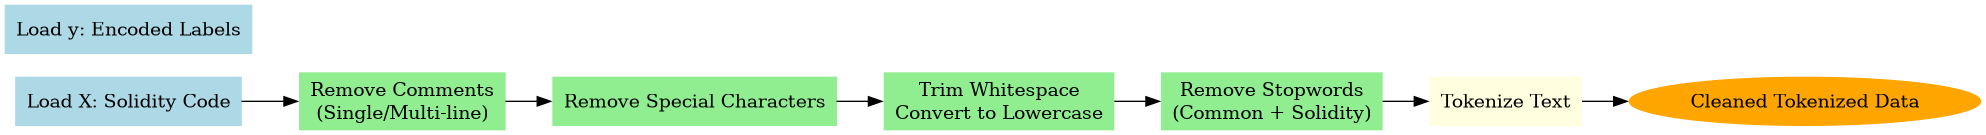

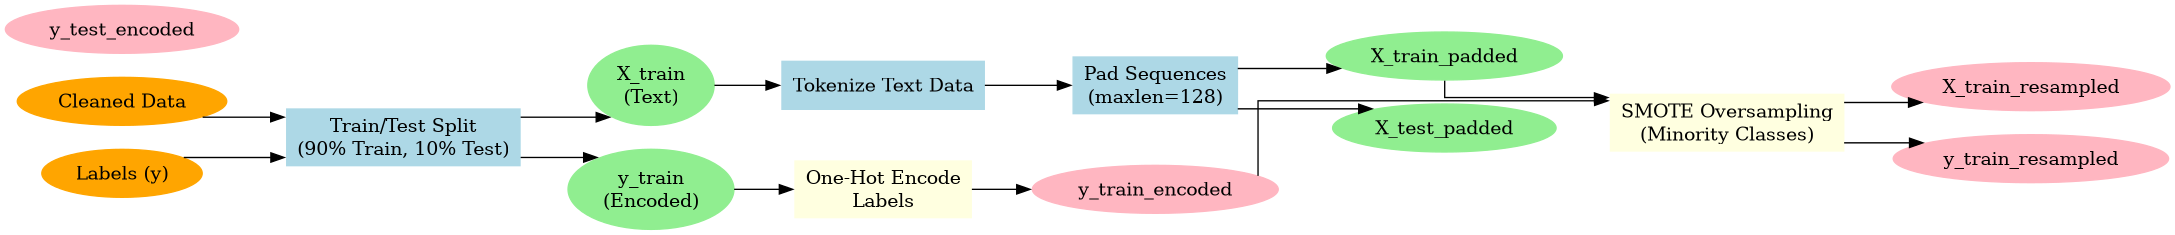

In [63]:
from graphviz import Digraph
from IPython.display import Image, display

def create_preprocessing_diagram_1():
    dot = Digraph(format="png", engine="dot")
    dot.attr(rankdir="LR", splines="ortho", concentrate="true")

    # Data Loading and Target Variable
    dot.node("X", "Load X: Solidity Code", shape="box", style="filled", color="lightblue")
    dot.node("y", "Load y: Encoded Labels", shape="box", style="filled", color="lightblue")

    # Cleaning Steps
    dot.node("RemoveComments", "Remove Comments\n(Single/Multi-line)", shape="box", style="filled", color="lightgreen")
    dot.node("RemoveSpecialChars", "Remove Special Characters", shape="box", style="filled", color="lightgreen")
    dot.node("WhitespaceLowercase", "Trim Whitespace\nConvert to Lowercase", shape="box", style="filled", color="lightgreen")
    dot.node("RemoveStopwords", "Remove Stopwords\n(Common + Solidity)", shape="box", style="filled", color="lightgreen")
    dot.node("Tokenize", "Tokenize Text", shape="box", style="filled", color="lightyellow")

    # Result
    dot.node("Cleaned", "Cleaned Tokenized Data", shape="ellipse", style="filled", color="orange")

    # Workflow
    dot.edges([
        ("X", "RemoveComments"),
        ("RemoveComments", "RemoveSpecialChars"),
        ("RemoveSpecialChars", "WhitespaceLowercase"),
        ("WhitespaceLowercase", "RemoveStopwords"),
        ("RemoveStopwords", "Tokenize"),
        ("Tokenize", "Cleaned"),
    ])

    return dot


def create_preprocessing_diagram_2():
    dot = Digraph(format="png", engine="dot")
    dot.attr(rankdir="LR", splines="ortho", concentrate="true")

    # Input
    dot.node("Cleaned", "Cleaned Data", shape="ellipse", style="filled", color="orange")
    dot.node("y", "Labels (y)", shape="ellipse", style="filled", color="orange")

    # Data Splitting
    dot.node("Split", "Train/Test Split\n(90% Train, 10% Test)", shape="box", style="filled", color="lightblue")
    dot.node("X_train", "X_train\n(Text)", shape="ellipse", style="filled", color="lightgreen")
    dot.node("y_train", "y_train\n(Encoded)", shape="ellipse", style="filled", color="lightgreen")

    # Label Encoding
    dot.node("OneHot", "One-Hot Encode\nLabels", shape="box", style="filled", color="lightyellow")
    dot.node("y_train_encoded", "y_train_encoded", shape="ellipse", style="filled", color="lightpink")
    dot.node("y_test_encoded", "y_test_encoded", shape="ellipse", style="filled", color="lightpink")

    # Tokenization and Padding
    dot.node("Tokenize", "Tokenize Text Data", shape="box", style="filled", color="lightblue")
    dot.node("Pad", "Pad Sequences\n(maxlen=128)", shape="box", style="filled", color="lightblue")
    dot.node("X_train_padded", "X_train_padded", shape="ellipse", style="filled", color="lightgreen")
    dot.node("X_test_padded", "X_test_padded", shape="ellipse", style="filled", color="lightgreen")

    # SMOTE Oversampling
    dot.node("SMOTE", "SMOTE Oversampling\n(Minority Classes)", shape="box", style="filled", color="lightyellow")
    dot.node("X_train_resampled", "X_train_resampled", shape="ellipse", style="filled", color="lightpink")
    dot.node("y_train_resampled", "y_train_resampled", shape="ellipse", style="filled", color="lightpink")

    # Workflow
    dot.edges([
        ("Cleaned", "Split"),
        ("y", "Split"),
        ("Split", "X_train"),
        ("Split", "y_train"),
        ("X_train", "Tokenize"),
        ("Tokenize", "Pad"),
        ("Pad", "X_train_padded"),
        ("Pad", "X_test_padded"),
        ("y_train", "OneHot"),
        ("OneHot", "y_train_encoded"),
        ("y_train_encoded", "SMOTE"),
        ("X_train_padded", "SMOTE"),
        ("SMOTE", "X_train_resampled"),
        ("SMOTE", "y_train_resampled"),
    ])

    return dot


# Generate and Display Diagram 1
diagram1 = create_preprocessing_diagram_1()
diagram1.render("preprocessing_step1", cleanup=True)
display(Image(filename="preprocessing_step1.png"))

# Generate and Display Diagram 2
diagram2 = create_preprocessing_diagram_2()
diagram2.render("preprocessing_step2", cleanup=True)
display(Image(filename="preprocessing_step2.png"))


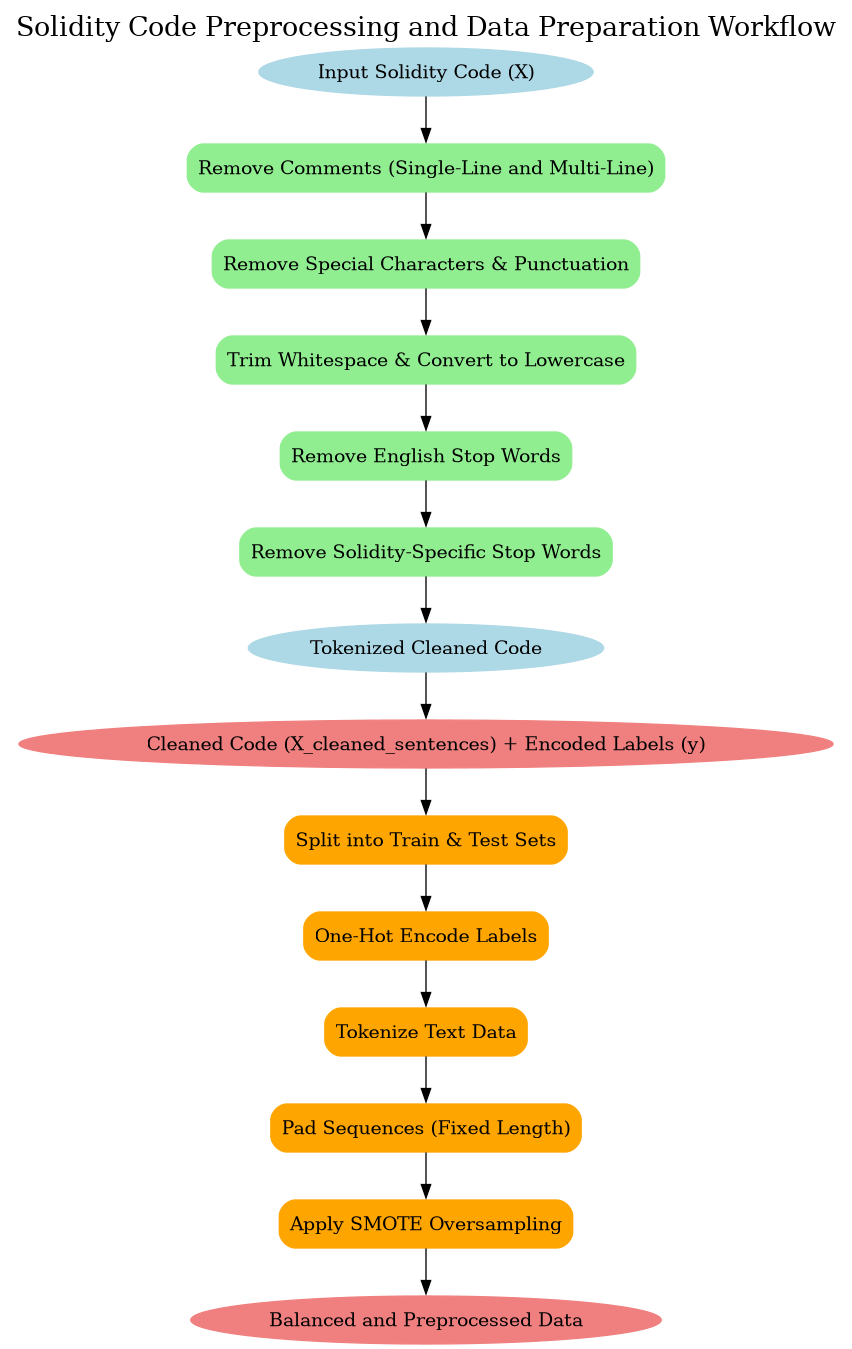

In [64]:
from graphviz import Digraph
from IPython.display import Image, display

# Initialize a single combined diagram
diagram = Digraph("Preprocessing Workflow", format="png")

diagram.attr(rankdir="TB", style="filled", color="lightgrey", fontsize="20", labeljust="center", labelloc="top", label="Solidity Code Preprocessing and Data Preparation Workflow")

# Diagram 1: Preprocessing Solidity Code
diagram.node("InputCode", "Input Solidity Code (X)", shape="ellipse", style="filled", color="lightblue")
diagram.node("RemoveComments", "Remove Comments (Single-Line and Multi-Line)", shape="box", style="rounded,filled", color="lightgreen")
diagram.node("RemoveSpecialChars", "Remove Special Characters & Punctuation", shape="box", style="rounded,filled", color="lightgreen")
diagram.node("WhitespaceLowercase", "Trim Whitespace & Convert to Lowercase", shape="box", style="rounded,filled", color="lightgreen")
diagram.node("RemoveStopWords", "Remove English Stop Words", shape="box", style="rounded,filled", color="lightgreen")
diagram.node("RemoveSolidityStopWords", "Remove Solidity-Specific Stop Words", shape="box", style="rounded,filled", color="lightgreen")
diagram.node("OutputTokens", "Tokenized Cleaned Code", shape="ellipse", style="filled", color="lightblue")

# Connect nodes for Diagram 1
diagram.edges([
    ("InputCode", "RemoveComments"),
    ("RemoveComments", "RemoveSpecialChars"),
    ("RemoveSpecialChars", "WhitespaceLowercase"),
    ("WhitespaceLowercase", "RemoveStopWords"),
    ("RemoveStopWords", "RemoveSolidityStopWords"),
    ("RemoveSolidityStopWords", "OutputTokens")
])

# Diagram 2: Data Splitting and Processing
diagram.node("InputData", "Cleaned Code (X_cleaned_sentences) + Encoded Labels (y)", shape="ellipse", style="filled", color="lightcoral")
diagram.node("TrainTestSplit", "Split into Train & Test Sets", shape="box", style="rounded,filled", color="orange")
diagram.node("OneHotEncode", "One-Hot Encode Labels", shape="box", style="rounded,filled", color="orange")
diagram.node("Tokenization", "Tokenize Text Data", shape="box", style="rounded,filled", color="orange")
diagram.node("Padding", "Pad Sequences (Fixed Length)", shape="box", style="rounded,filled", color="orange")
diagram.node("SMOTE", "Apply SMOTE Oversampling", shape="box", style="rounded,filled", color="orange")
diagram.node("FinalOutput", "Balanced and Preprocessed Data", shape="ellipse", style="filled", color="lightcoral")

# Connect nodes for Diagram 2
diagram.edges([
    ("OutputTokens", "InputData"),
    ("InputData", "TrainTestSplit"),
    ("TrainTestSplit", "OneHotEncode"),
    ("OneHotEncode", "Tokenization"),
    ("Tokenization", "Padding"),
    ("Padding", "SMOTE"),
    ("SMOTE", "FinalOutput")
])

# Render the combined diagram
diagram.render("combined_preprocessing_workflow")

# Display the image in the notebook
display(Image(filename="combined_preprocessing_workflow.png"))


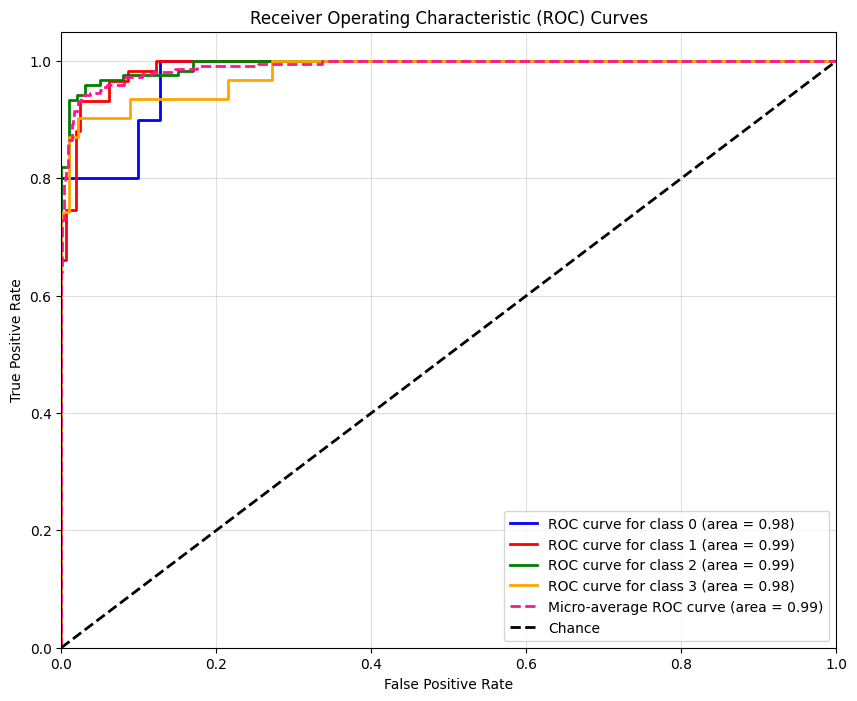

In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC computation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Replace with your class indices [0, 1, 2, 3]
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {labels[i]} (area = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})')

# Plot diagonal (no-discrimination) line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.4)
plt.show()
